/home/liusong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  


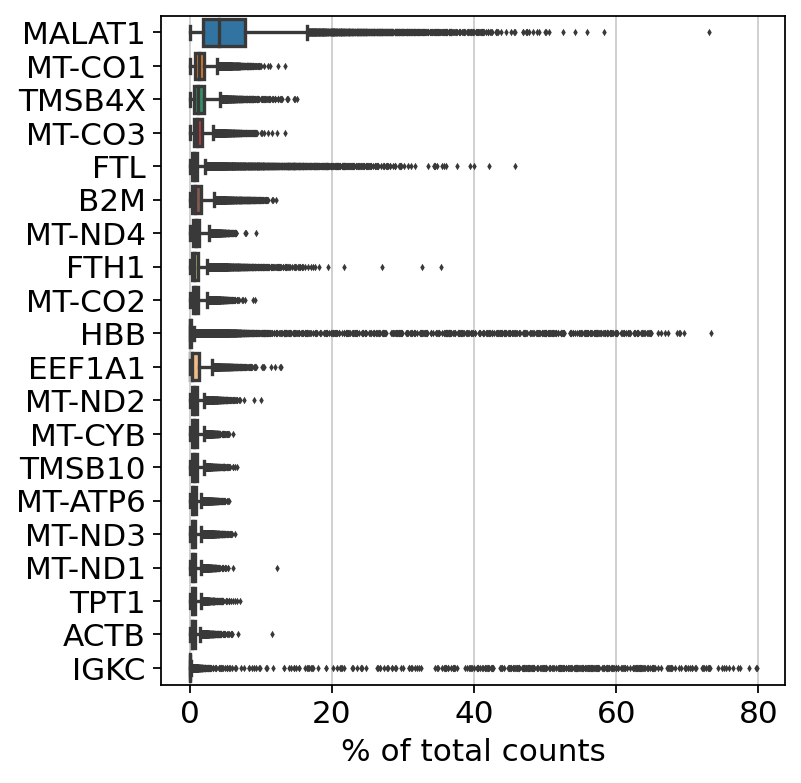

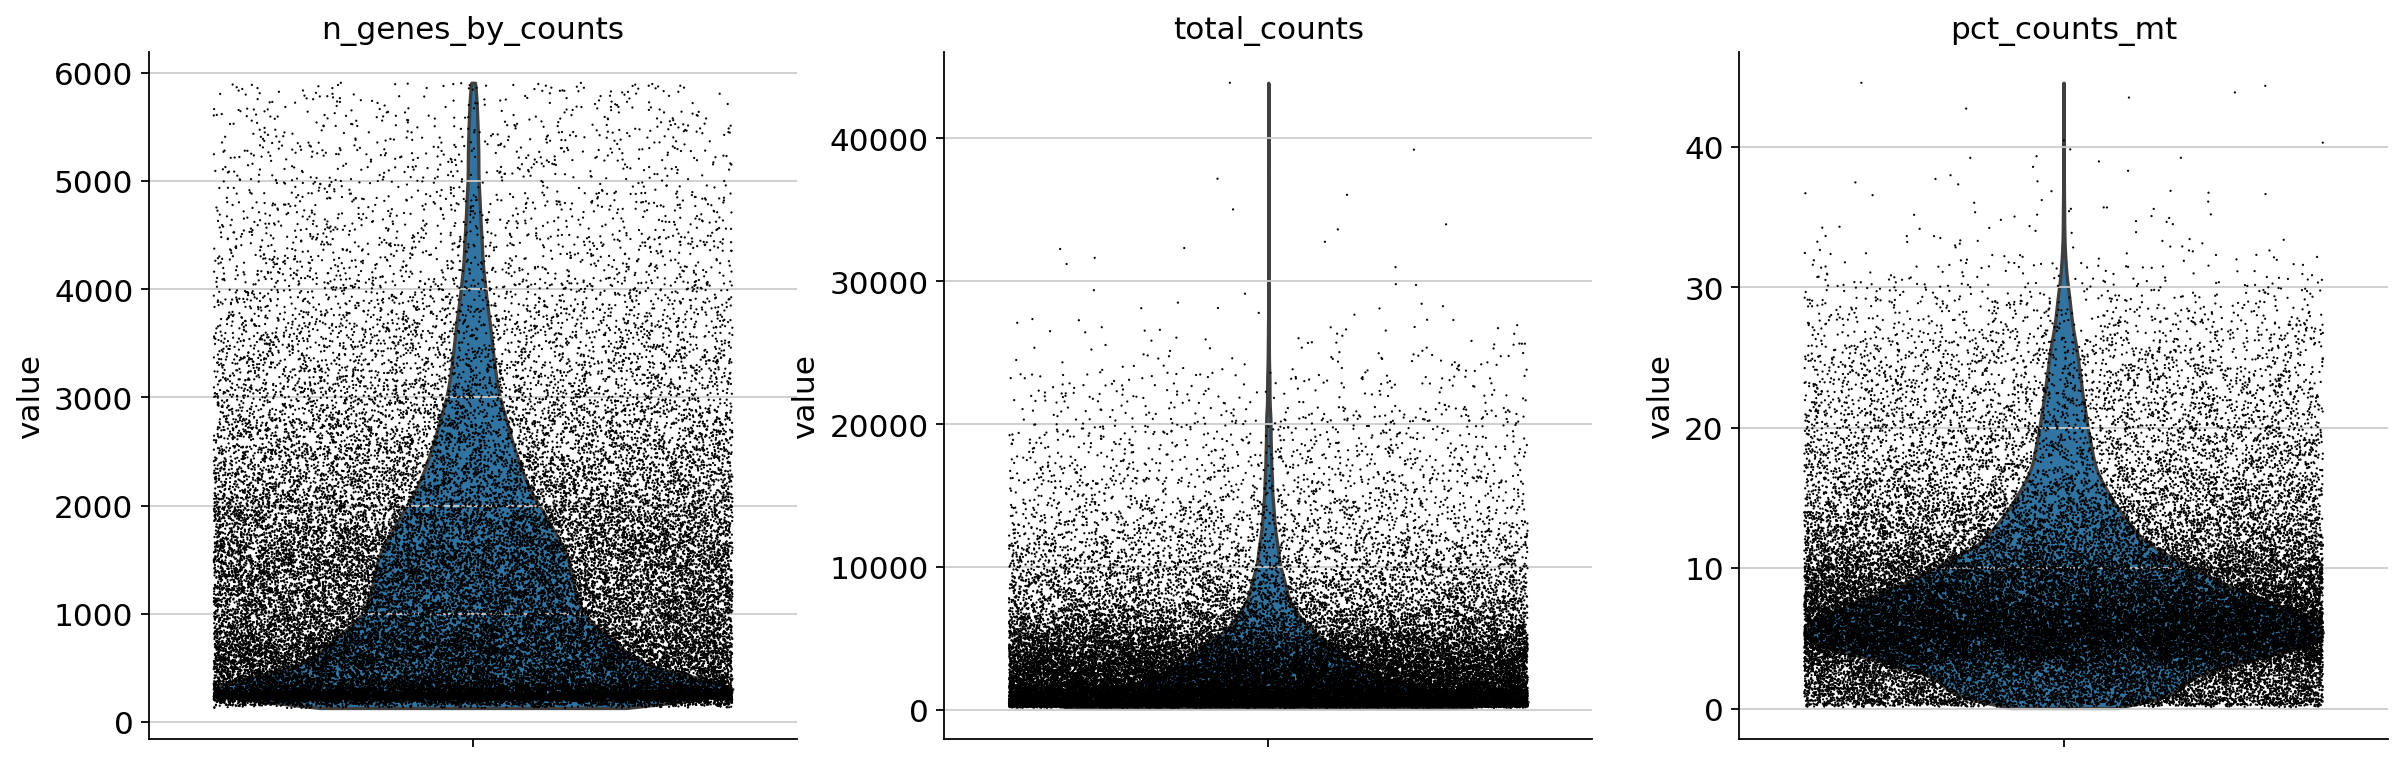

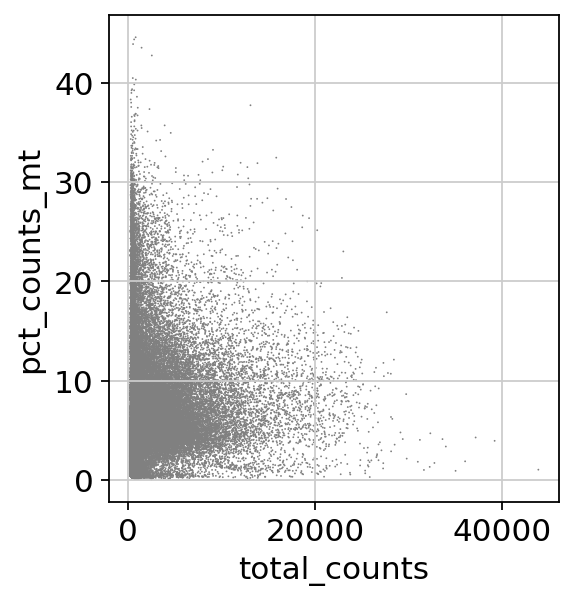

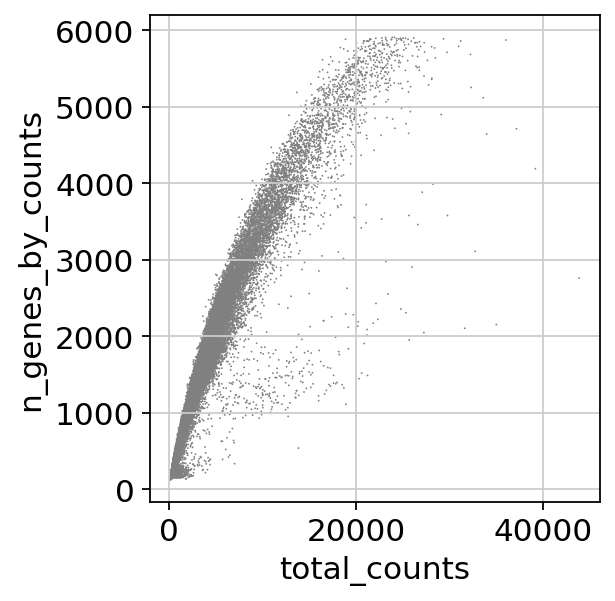

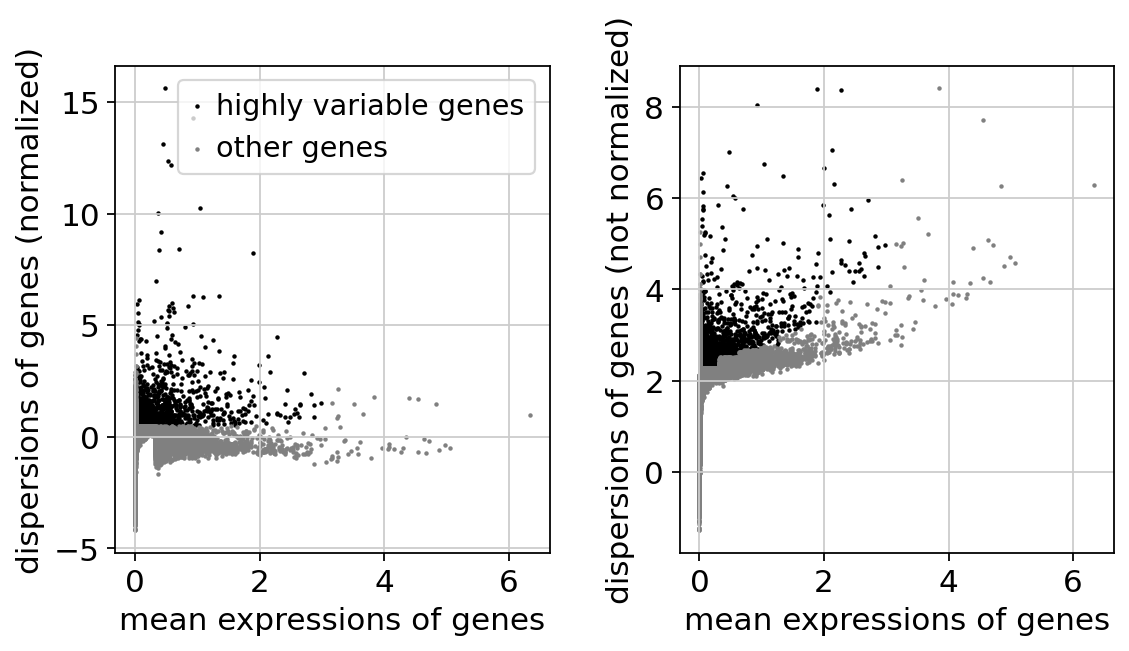

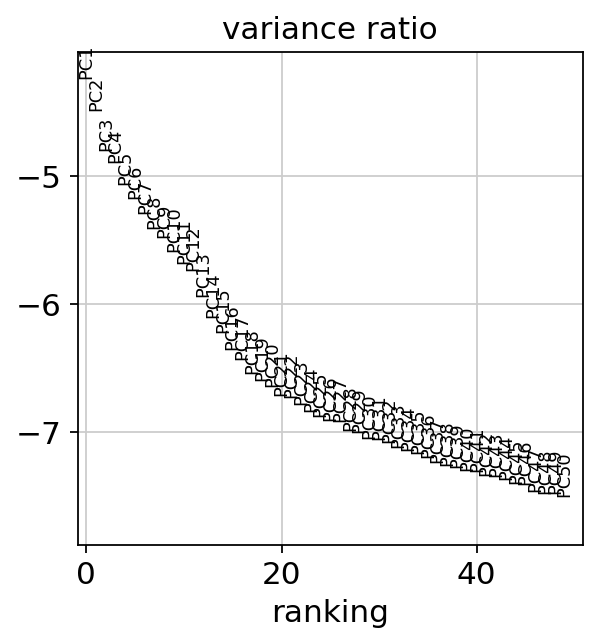

,Cell,nGene,nUMI,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType
0,BT1303_AAACCTGAGAGCCCAA,208,951,1,11,Ovarian,Omentum,Cancer
1,BT1303_AAACCTGAGGCATGGT,249,421,1,11,Ovarian,Omentum,T_cell
2,BT1303_AAACCTGAGTATTGGA,226,407,1,11,Ovarian,Omentum,Cancer
3,BT1303_AAACCTGAGTGCAAGC,1433,2992,1,11,Ovarian,Omentum,Fibroblast
4,BT1303_AAACCTGAGTGGTAAT,259,409,1,11,Ovarian,Omentum,Cancer
...,...,...,...,...,...,...,...,...
45109,scrSOL007_TTTGTCAGTACCGAGA,1812,6436,0,15,Ovarian,Ovarium,Fibroblast
45110,scrSOL007_TTTGTCAGTGAAAGAG,1102,2940,0,15,Ovarian,Ovarium,Fibroblast
45111,scrSOL007_TTTGTCAGTGAAGGCT,1080,2737,0,15,Ovarian,Ovarium,Myeloid
45112,scrSOL007_TTTGTCATCAGCCTAA,323,1325,0,15,Ovarian,Ovarium,Fibroblast


In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import scanpy.external as sce
import bbknn
sc.set_figure_params(dpi_save=300)

Cancerdata=sc.read_10x_mtx("/home/liusong/scRNA/endometriosis/V3data/Downloaded_Ovary_cancer/CellResearch/OvC_counts",var_names='gene_symbols')
Cancerdata.var_names_make_unique()
ribosomes=Cancerdata.var_names.str.match("^RP[LS]")
Cancerdata=Cancerdata[:,~ribosomes]

Cancerdata.var['mt']=Cancerdata.var_names.str.startswith('MT-')
sc.pl.highest_expr_genes(Cancerdata,n_top=20)
Cancerdata
sc.pp.calculate_qc_metrics(Cancerdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(Cancerdata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)

sc.pl.scatter(Cancerdata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(Cancerdata, x='total_counts', y='n_genes_by_counts')
sc.pp.normalize_total(Cancerdata, target_sum=1e4)
sc.pp.log1p(Cancerdata)

sc.pp.highly_variable_genes(Cancerdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(Cancerdata)
Cancerdata.raw = Cancerdata

Cancerdata = Cancerdata[:, Cancerdata.var.highly_variable]
sc.pp.regress_out(Cancerdata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(Cancerdata, max_value=10)

sc.tl.pca(Cancerdata, svd_solver='arpack')
sc.pl.pca_variance_ratio(Cancerdata, log=True,n_pcs=50)

metadata=pd.read_csv("/home/liusong/scRNA/endometriosis/V3data/Downloaded_Ovary_cancer/CellResearch/2101-Ovariancancer_metadata.csv")
metadata

In [8]:
Cancerdata.obs
Cancerdata.obs['sampleID']=list(metadata['PatientNumber'])
Cancerdata.obs['TumorType']=list(metadata['TumorType'])
Cancerdata.obs['TumorSite']=list(metadata['TumorSite'])
Cancerdata.obs['CellType']=list(metadata['CellType'])
Cancerdata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sampleID,TumorType,TumorSite,CellType,louvain,leiden
BT1303_AAACCTGAGAGCCCAA,155,858.0,7.0,0.815851,11,Ovarian,Omentum,Cancer,0,0
BT1303_AAACCTGAGGCATGGT,215,373.0,81.0,21.715818,11,Ovarian,Omentum,T_cell,14,15
BT1303_AAACCTGAGTATTGGA,175,310.0,79.0,25.483871,11,Ovarian,Omentum,Cancer,25,19
BT1303_AAACCTGAGTGCAAGC,1358,2594.0,253.0,9.753277,11,Ovarian,Omentum,Fibroblast,26,18
BT1303_AAACCTGAGTGGTAAT,202,269.0,7.0,2.602231,11,Ovarian,Omentum,Cancer,0,0
...,...,...,...,...,...,...,...,...,...,...
scrSOL007_TTTGTCAGTACCGAGA,1732,3576.0,221.0,6.180089,15,Ovarian,Ovarium,Fibroblast,1,3
scrSOL007_TTTGTCAGTGAAAGAG,1024,1884.0,171.0,9.076433,15,Ovarian,Ovarium,Fibroblast,1,3
scrSOL007_TTTGTCAGTGAAGGCT,999,1853.0,116.0,6.260118,15,Ovarian,Ovarium,Myeloid,23,21
scrSOL007_TTTGTCATCAGCCTAA,248,504.0,101.0,20.039682,15,Ovarian,Ovarium,Fibroblast,34,38


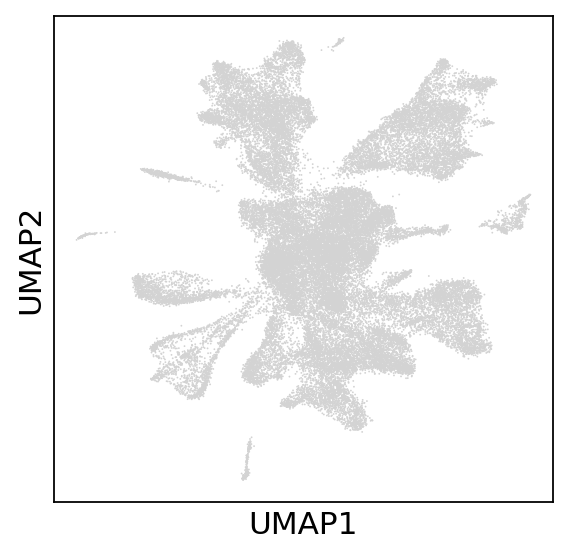

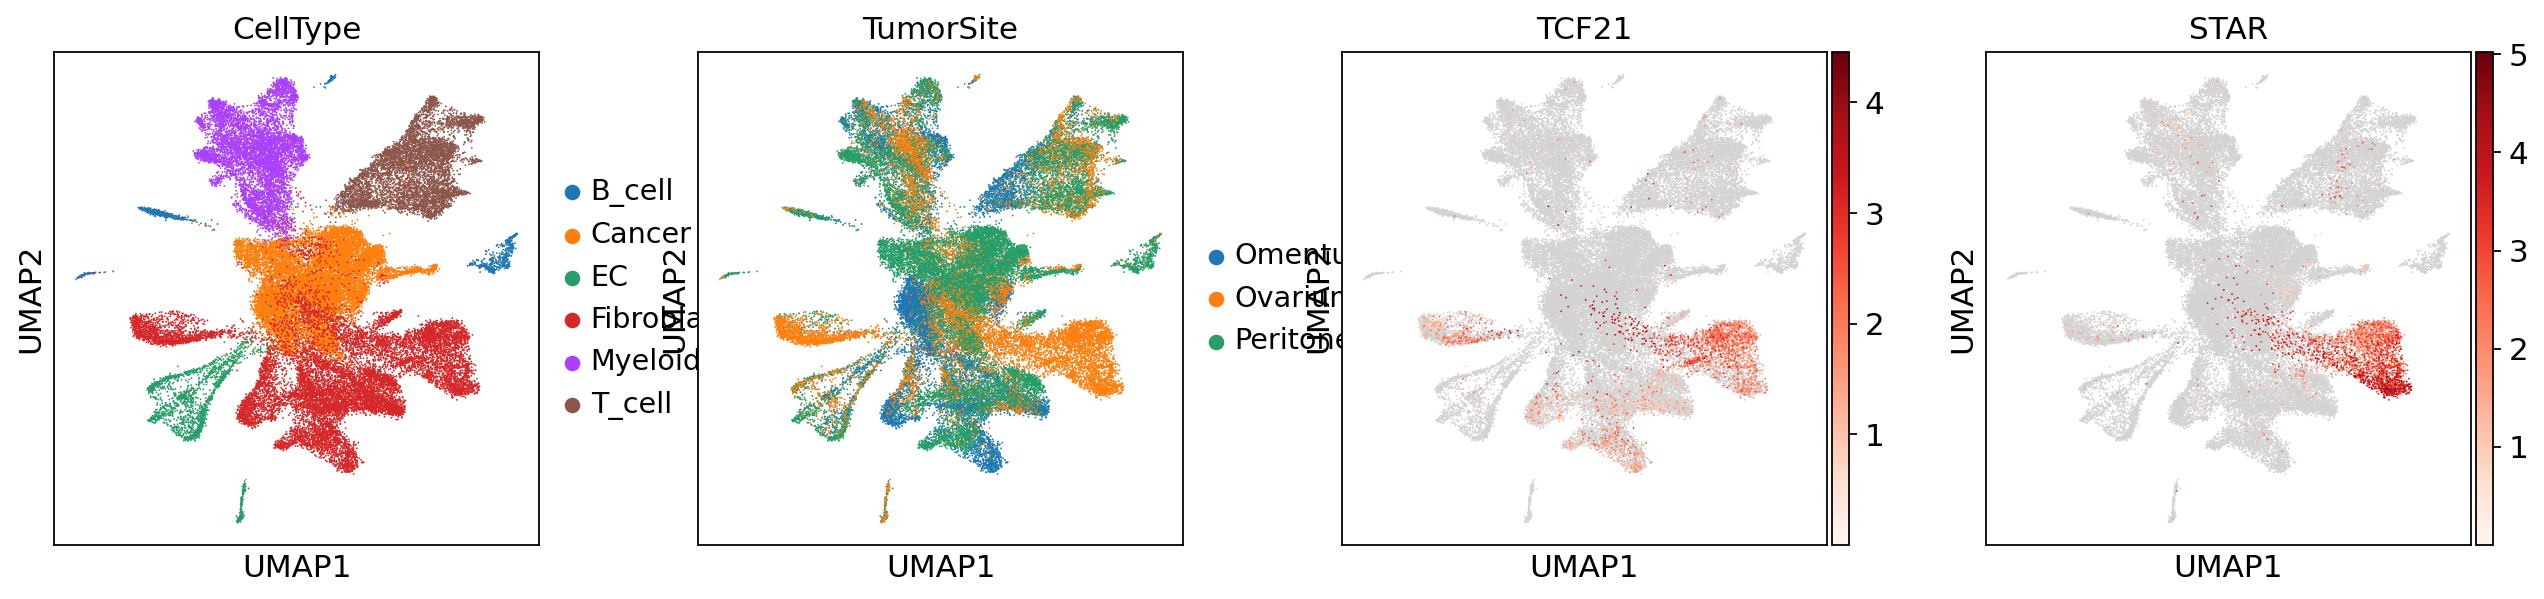

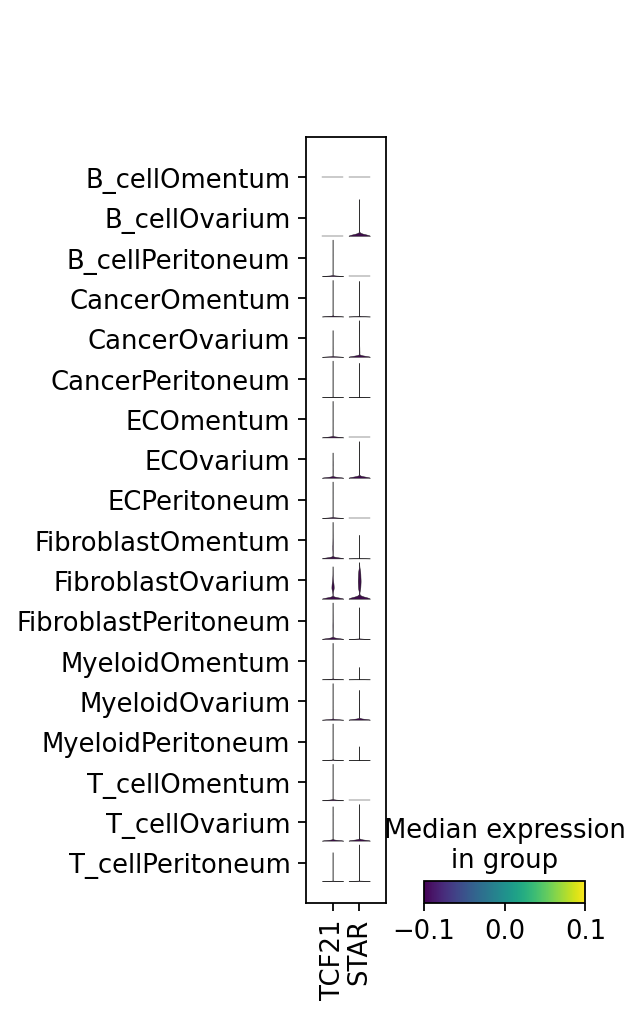

In [14]:
bbknn.bbknn(Cancerdata,batch_key='sampleID')
sc.tl.umap(Cancerdata)
sc.pl.umap(Cancerdata)
sc.tl.louvain(Cancerdata)
sc.tl.leiden(Cancerdata)
Cancerdata

import matplotlib as mpl
from copy import copy
reds = copy(mpl.cm.Reds)
reds.set_under("lightgray")

sc.pl.umap(Cancerdata,color=['CellType','TumorSite','TCF21','STAR'],cmap=reds, vmin=0.00001)
Cancerdata.obs['mygroup']=Cancerdata.obs['CellType'].astype('str')+Cancerdata.obs['TumorSite'].astype('str')
sc.pl.stacked_violin(Cancerdata,['TCF21','STAR'],groupby="mygroup",cmap=None)
#Cancerdata.write("Cancerdata_umap_BBKNN_scanpy.h5ad")